# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [1.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)

In [ ]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [ ]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class Tanh(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.zeros((1, output_size))
        self.input = None

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        return np.tanh(np.dot(self.input, self.weights.T) + self.bias)

    def backward(self, output_error_derivative:np.ndarray)->np.ndarray:
        tanh_derivative = (1 - (np.tanh(self.input)**2))

        self.weights += -self.learning_rate * np.transpose(output_error_derivative).dot(self.input)
        self.bias += -self.learning_rate * output_error_derivative

        input_error_derivative = output_error_derivative.dot(self.weights)
        input_error_derivative = input_error_derivative * tanh_derivative

        return input_error_derivative


class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:int)->np.ndarray:
        """Loss function for a particular x and y"""
        return self.loss_function(x, self._get_perfect_output_matrix(len(x), y))

    def loss_derivative(self, x:np.ndarray, y:int)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, self._get_perfect_output_matrix(len(x), y))

    def _get_perfect_output_matrix(self, size:int, number:int)->np.ndarray:
        matrix = np.full((1, size + 1), -1)
        matrix[0][number] = 1
        return matrix

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss = None

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def test_accuracy(self, x_test, y_test):
        sum_accurate = 0
        for x, y in zip(x_test, y_test):
            prediction = np.argmax(self(x))
            sum_accurate += int(prediction == y)
        accuracy = sum_accurate / len(x_test)
        return accuracy

    def fit(self, x_train: np.ndarray,
                  y_train: np.ndarray,
                  epochs: int,
                  x_test: np.ndarray,
                  y_test: np.ndarray,
                  verbose: int = 0) -> tuple[dict[int], dict[int]]:
        for layer in self.layers:
            layer.learning_rate = self.learning_rate
        losses = dict()
        accuracies = dict()
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(x_train, y_train):
                x.shape += (1,)
                output = self(np.transpose(x))
                total_loss += self.loss.loss(output, y)
                error_derivative = self.loss.loss_derivative(output, y)
                for layer in reversed(self.layers):
                    error_derivative = layer.backward(error_derivative)
            losses[epoch] = total_loss/len(x_train)
            accuracies[epoch] = self.test_accuracy(x_test, y_test)
            if verbose > 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(x_train)}")
        return losses, accuracies

In [ ]:
def create_network(in_out: list[tuple[int, int]], learning_rate: float) -> Network:
    layers = [Tanh(x[0], x[1]) for x in in_out]
    network = Network(layers, learning_rate)
    loss_function = Loss(lambda x, y: ((1/(len(x))) * np.sum((x - y) ** 2)), lambda x, y: 2*(x - y))
    network.compile(loss_function)
    return network

In [ ]:
def train_network(network: Network, test_size: float, seed: int, epochs: int) -> tuple[dict[int: float], dict[int: float]]:
    digits = load_digits()

    x = digits.data
    y = digits.target

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
    losses, accuracies = network.fit(x_train, y_train, epochs, x_test, y_test)
    return losses, accuracies

In [ ]:
one_layer_network = create_network([(64, 10)], 0.01)
two_layer_network = create_network([(64, 32), (32, 10)], 0.005)
three_layer_network = create_network([(64, 128), (128, 32), (32, 10)], 0.001)

one_layer_losses, one_layer_accuracies = train_network(one_layer_network, 0.1, 123, 1000)
two_layer_losses, two_layer_accuracies = train_network(two_layer_network, 0.1, 123, 1000)
three_layer_losses, three_layer_accuracies = train_network(three_layer_network, 0.1, 123, 1000)

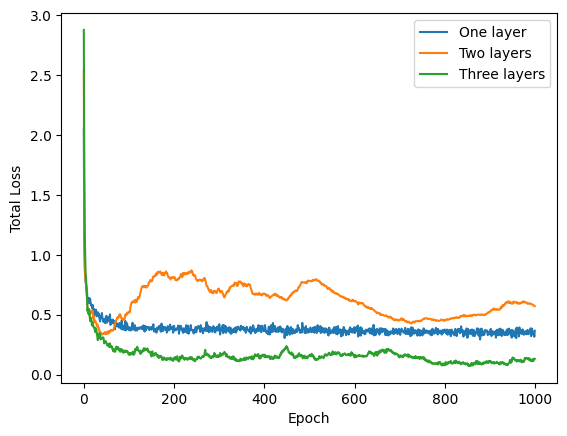

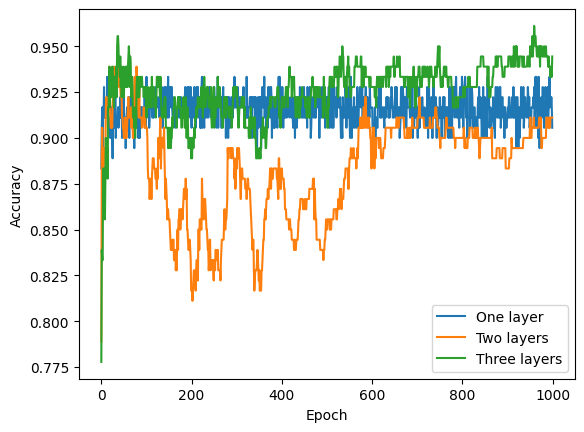

In [ ]:
keys = one_layer_losses.keys()
values1 = one_layer_losses.values()
values2 = two_layer_losses.values()
values3 = three_layer_losses.values()

plt.plot(keys, values1, label='One layer')
plt.plot(keys, values2, label='Two layers')
plt.plot(keys, values3, label='Three layers')

plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()

plt.show()

values1 = one_layer_accuracies.values()
values2 = two_layer_accuracies.values()
values3 = three_layer_accuracies.values()

plt.plot(keys, values1, label='One layer')
plt.plot(keys, values2, label='Two layers')
plt.plot(keys, values3, label='Three layers')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
seeds = [123, 42, 404]


for seed in seeds:
    digits = load_digits()
    x = digits.data
    y = digits.target
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
    print(f"One layer network accuracy on seed {seed} is {one_layer_network.test_accuracy(x_test, y_test)}")
print()
for seed in seeds:
    digits = load_digits()
    x = digits.data
    y = digits.target
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
    print(f"Two layer network accuracy on seed {seed} is {two_layer_network.test_accuracy(x_test, y_test)}")
print()
for seed in seeds:
    digits = load_digits()
    x = digits.data
    y = digits.target
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
    print(f"Three layer network accuracy on seed {seed} is {three_layer_network.test_accuracy(x_test, y_test)}")


One layer network accuracy on seed 123 is 0.9055555555555556
One layer network accuracy on seed 42 is 0.9777777777777777
One layer network accuracy on seed 404 is 0.9277777777777778

Two layer network accuracy on seed 123 is 0.9111111111111111
Two layer network accuracy on seed 42 is 0.9444444444444444
Two layer network accuracy on seed 404 is 0.8833333333333333

Three layer network accuracy on seed 123 is 0.9444444444444444
Three layer network accuracy on seed 42 is 0.9833333333333333
Three layer network accuracy on seed 404 is 0.9722222222222222


<Figure size 640x480 with 0 Axes>

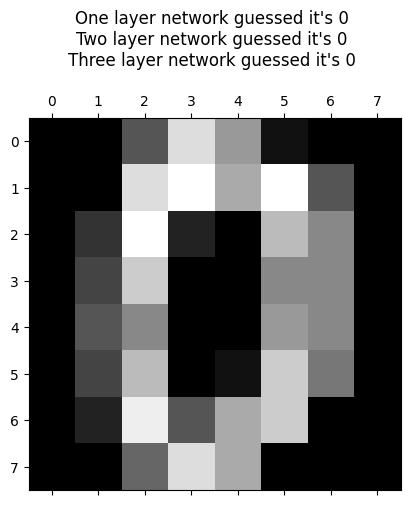

<Figure size 640x480 with 0 Axes>

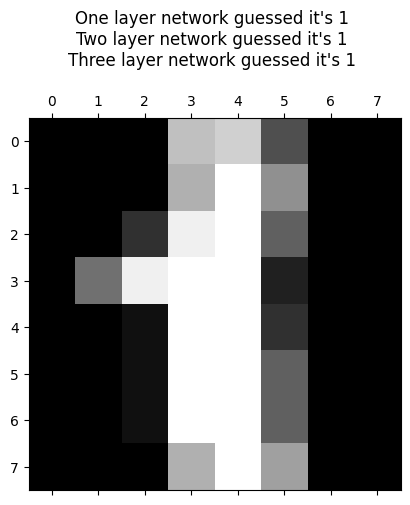

<Figure size 640x480 with 0 Axes>

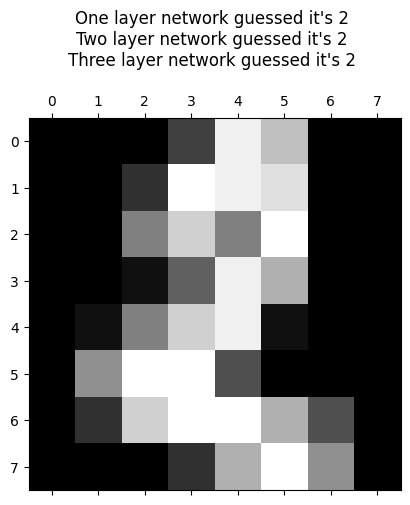

<Figure size 640x480 with 0 Axes>

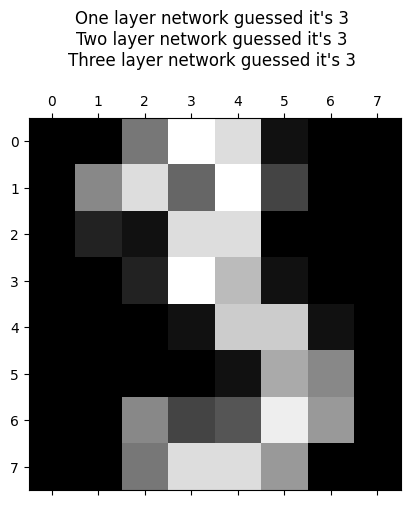

<Figure size 640x480 with 0 Axes>

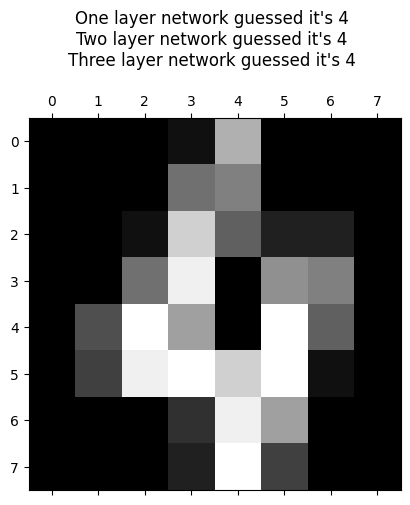

<Figure size 640x480 with 0 Axes>

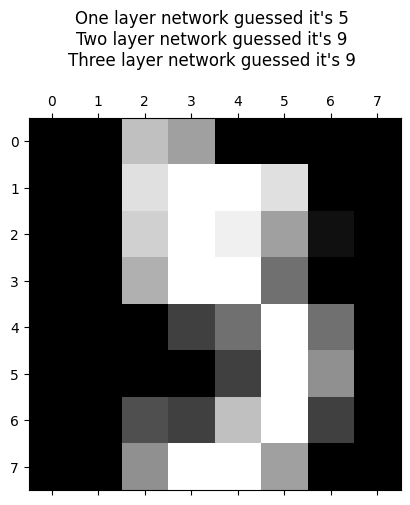

<Figure size 640x480 with 0 Axes>

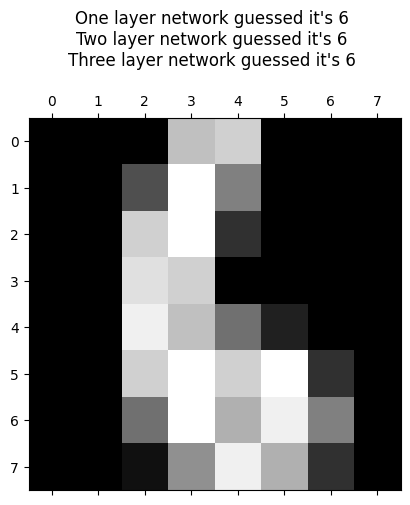

<Figure size 640x480 with 0 Axes>

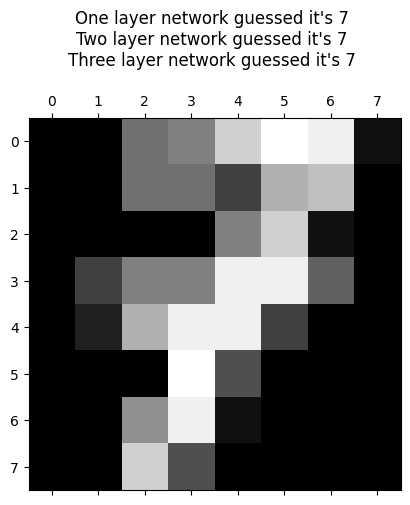

<Figure size 640x480 with 0 Axes>

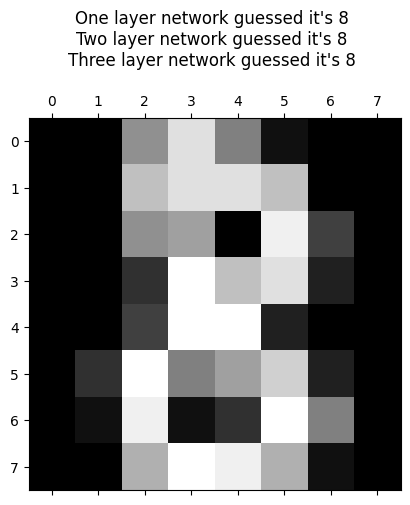

<Figure size 640x480 with 0 Axes>

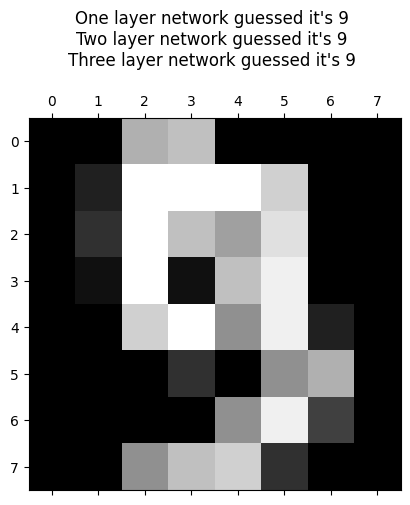

<Figure size 640x480 with 0 Axes>

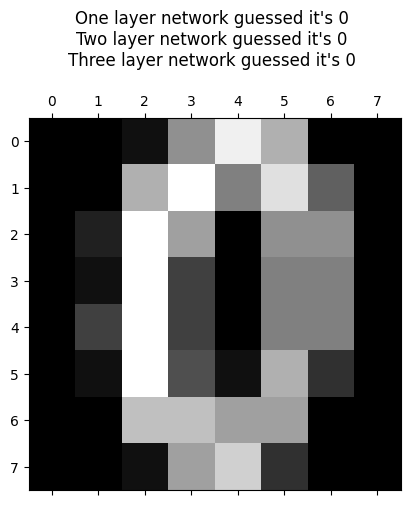

<Figure size 640x480 with 0 Axes>

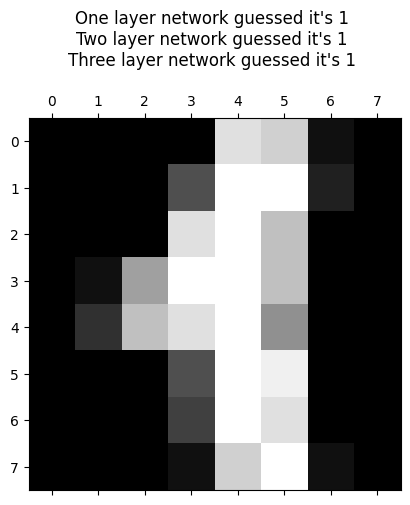

<Figure size 640x480 with 0 Axes>

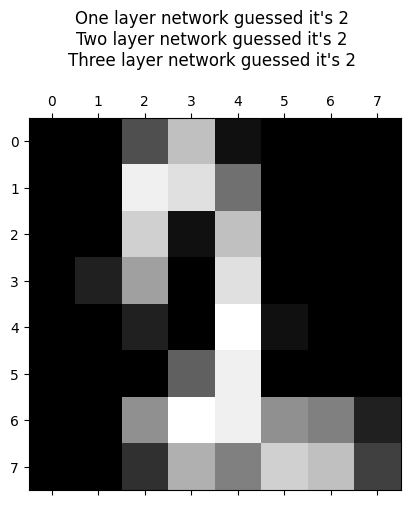

<Figure size 640x480 with 0 Axes>

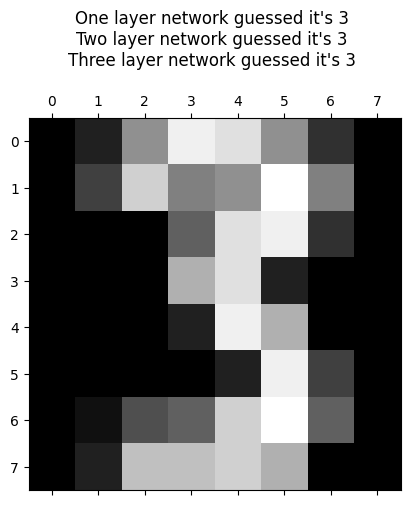

<Figure size 640x480 with 0 Axes>

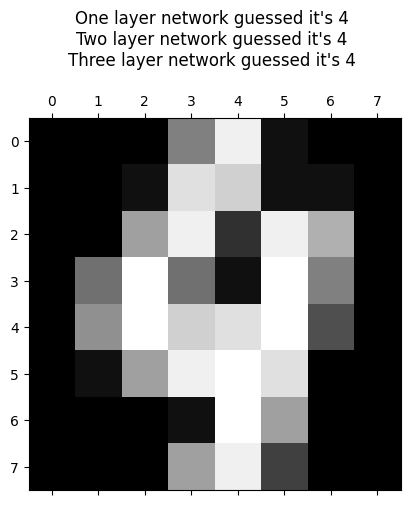

<Figure size 640x480 with 0 Axes>

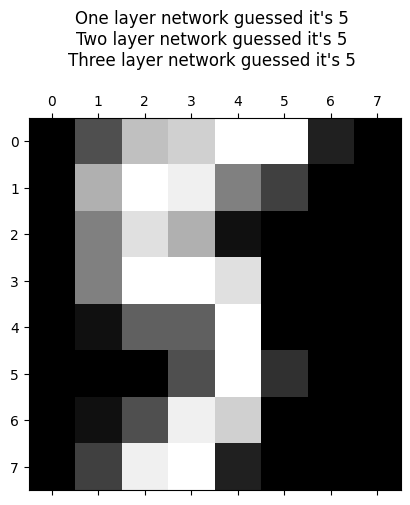

<Figure size 640x480 with 0 Axes>

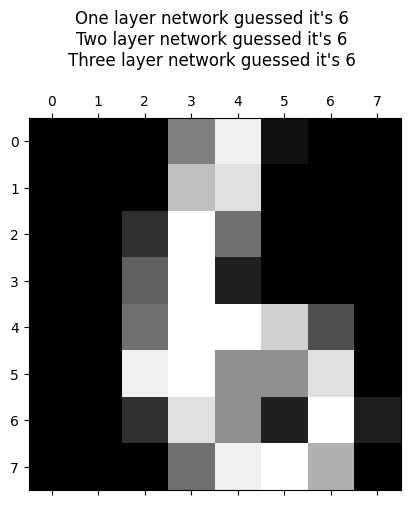

<Figure size 640x480 with 0 Axes>

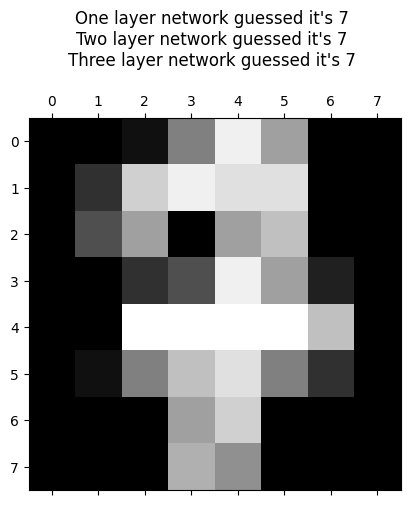

<Figure size 640x480 with 0 Axes>

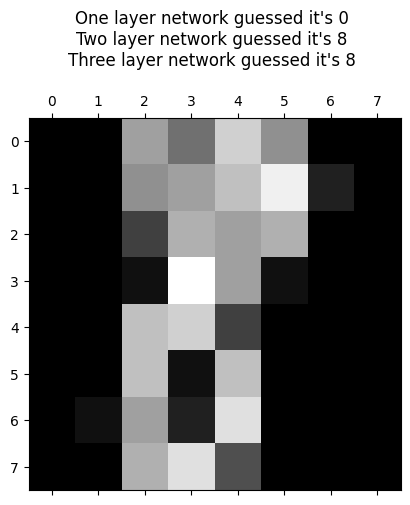

<Figure size 640x480 with 0 Axes>

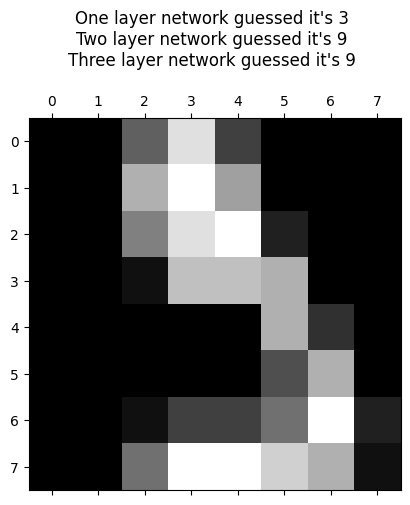

<Figure size 640x480 with 0 Axes>

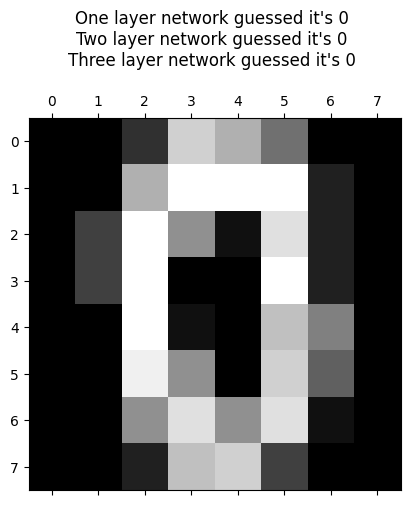

<Figure size 640x480 with 0 Axes>

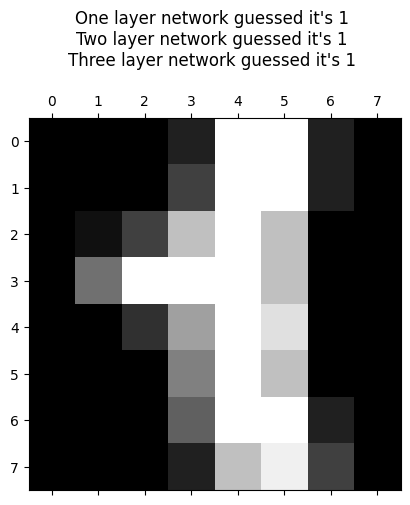

<Figure size 640x480 with 0 Axes>

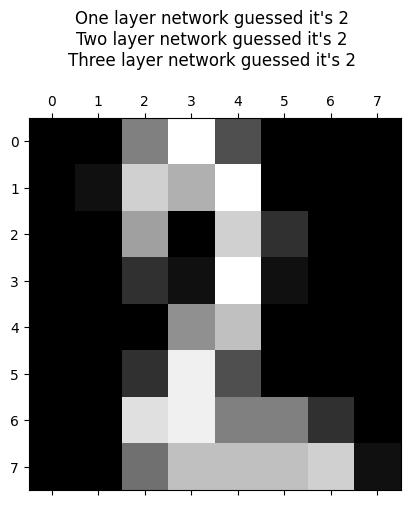

<Figure size 640x480 with 0 Axes>

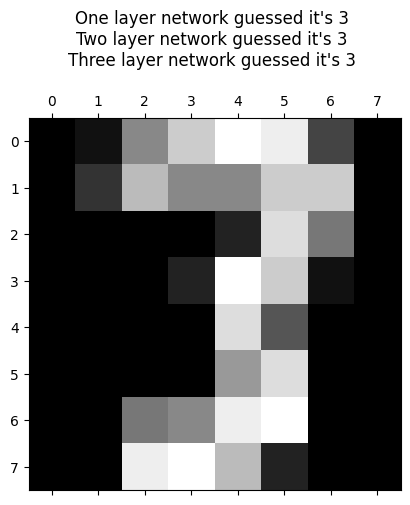

<Figure size 640x480 with 0 Axes>

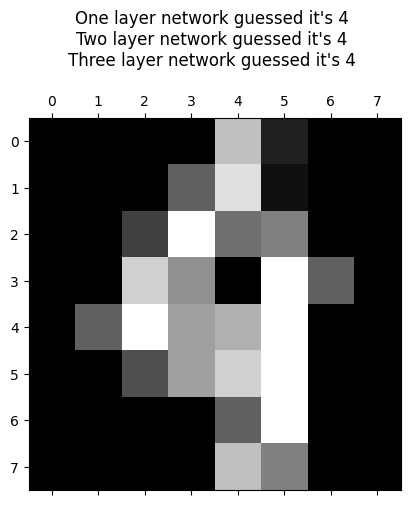

<Figure size 640x480 with 0 Axes>

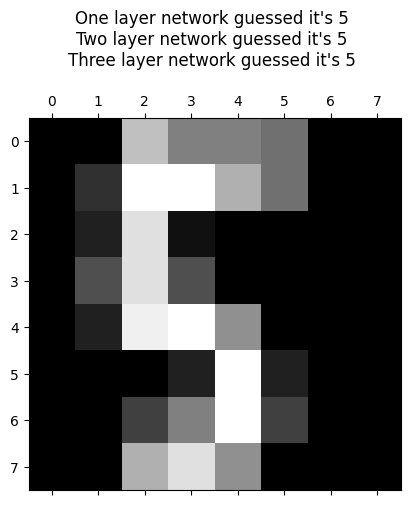

<Figure size 640x480 with 0 Axes>

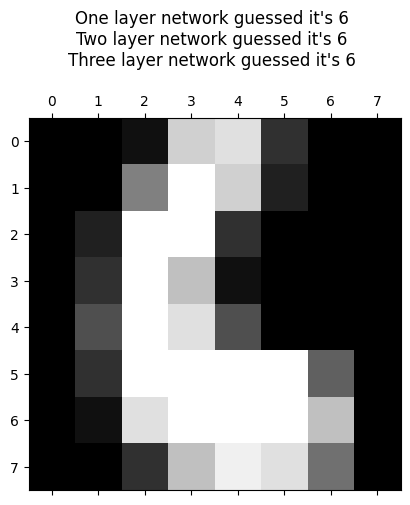

<Figure size 640x480 with 0 Axes>

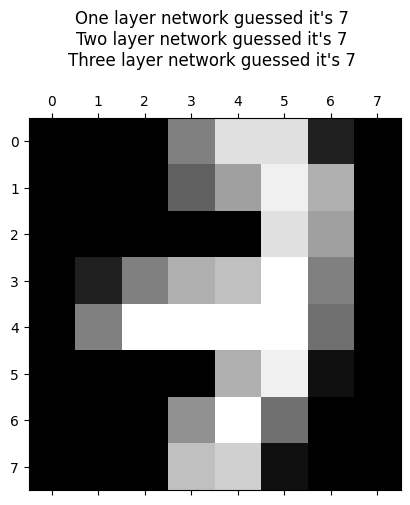

<Figure size 640x480 with 0 Axes>

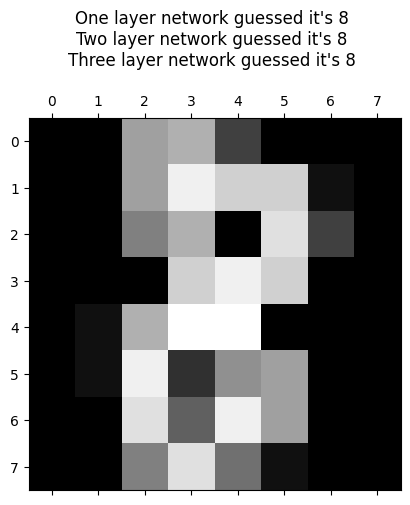

<Figure size 640x480 with 0 Axes>

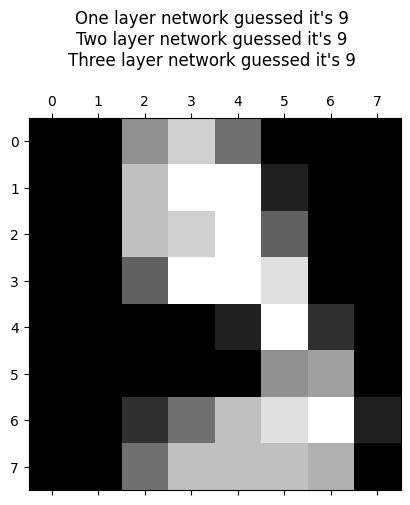

<Figure size 640x480 with 0 Axes>

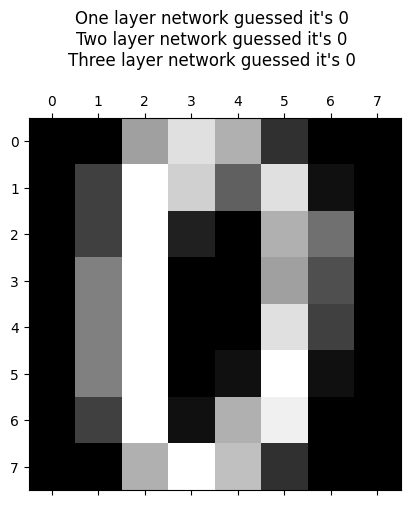

<Figure size 640x480 with 0 Axes>

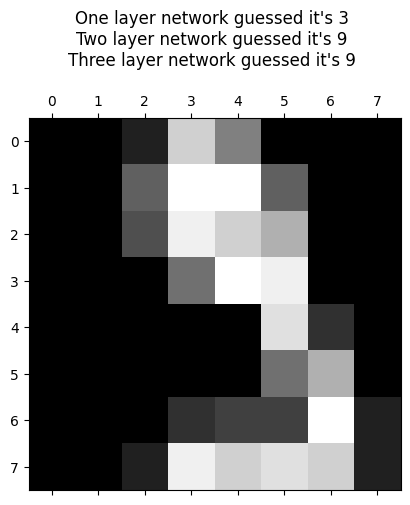

<Figure size 640x480 with 0 Axes>

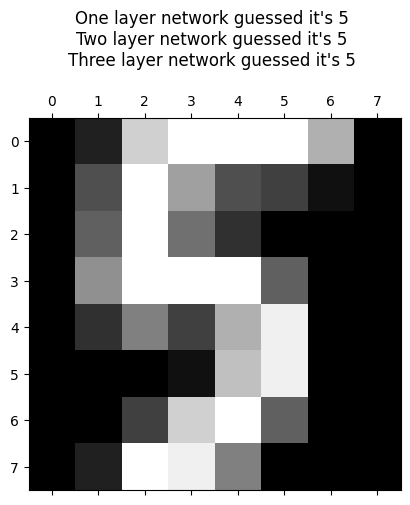

<Figure size 640x480 with 0 Axes>

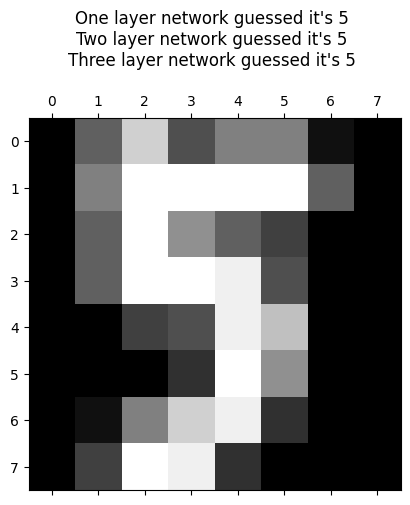

<Figure size 640x480 with 0 Axes>

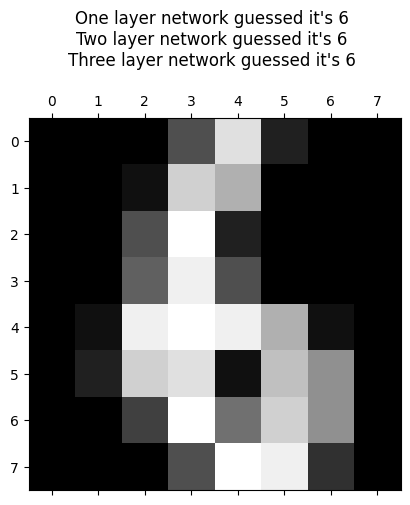

<Figure size 640x480 with 0 Axes>

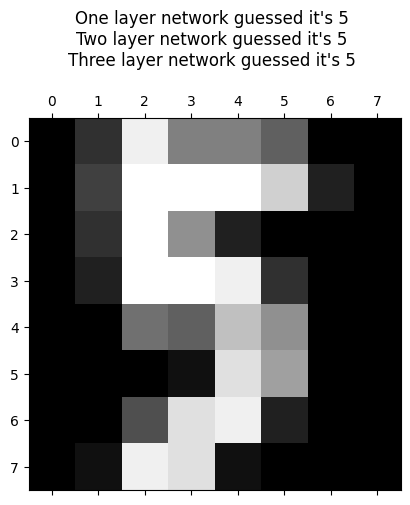

<Figure size 640x480 with 0 Axes>

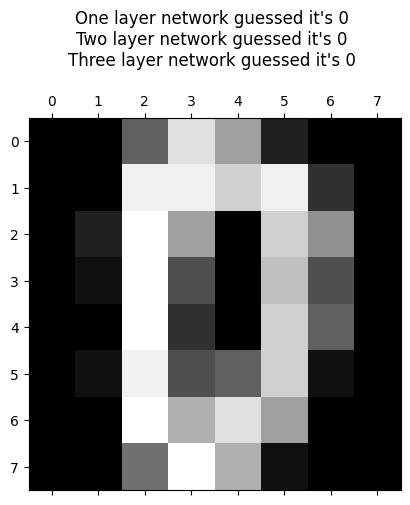

<Figure size 640x480 with 0 Axes>

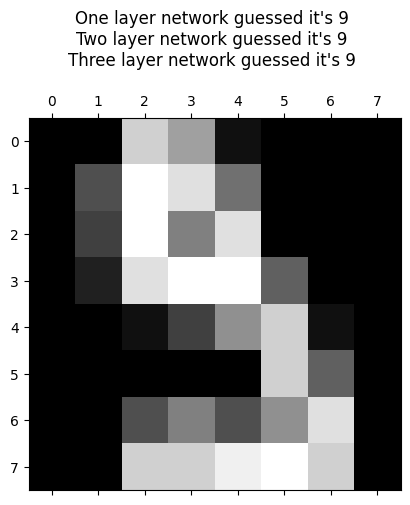

<Figure size 640x480 with 0 Axes>

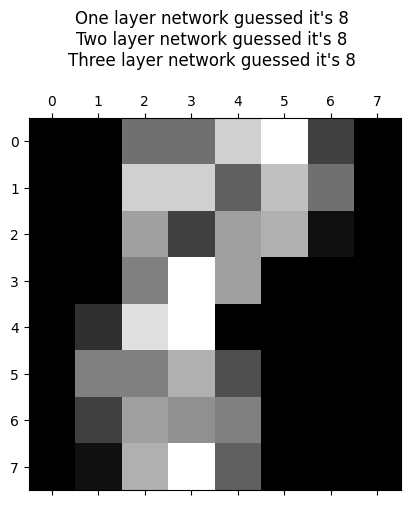

<Figure size 640x480 with 0 Axes>

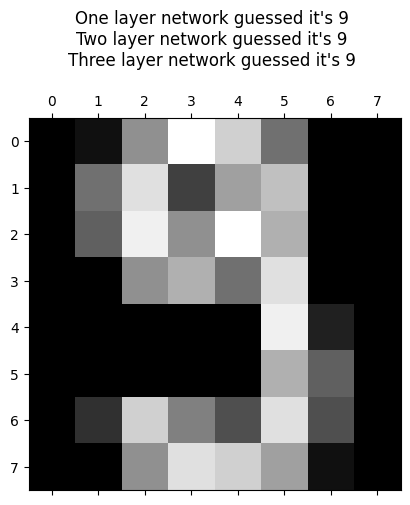

<Figure size 640x480 with 0 Axes>

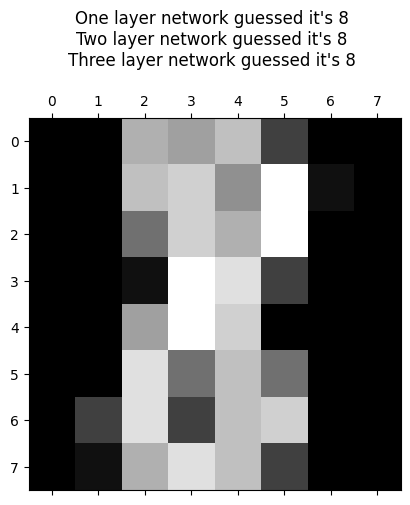

<Figure size 640x480 with 0 Axes>

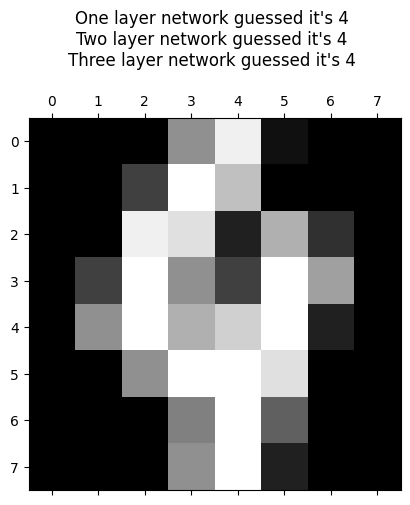

<Figure size 640x480 with 0 Axes>

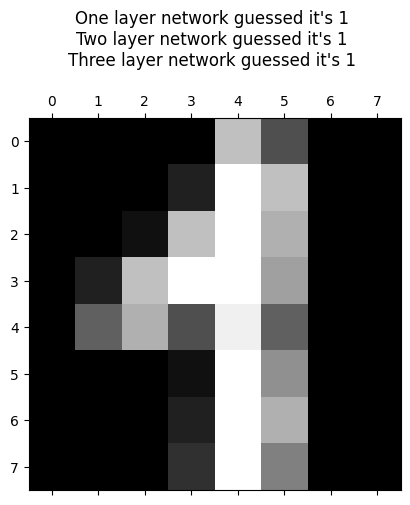

<Figure size 640x480 with 0 Axes>

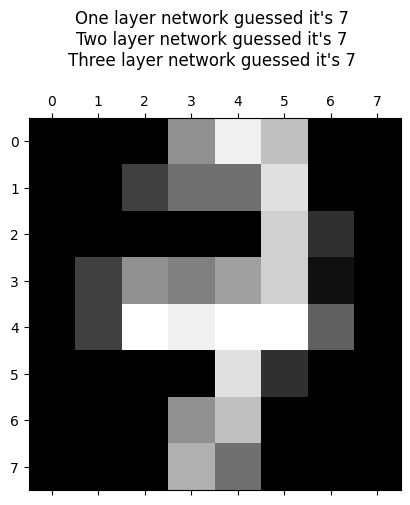

<Figure size 640x480 with 0 Axes>

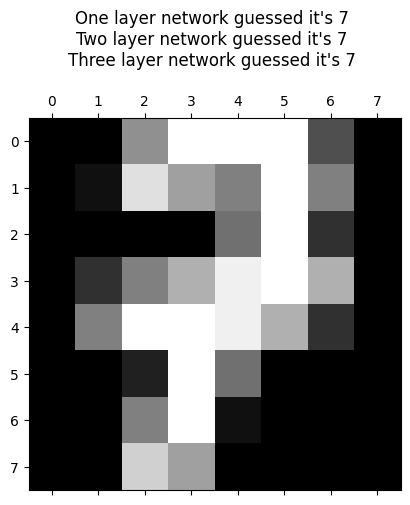

<Figure size 640x480 with 0 Axes>

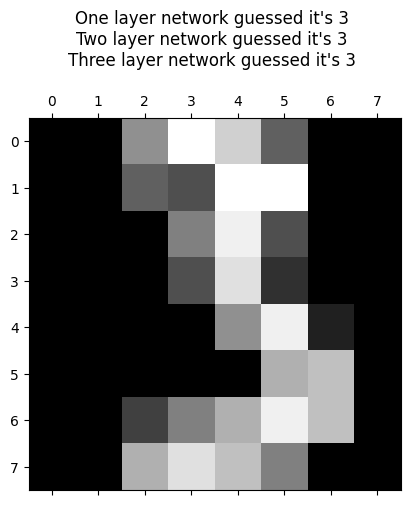

<Figure size 640x480 with 0 Axes>

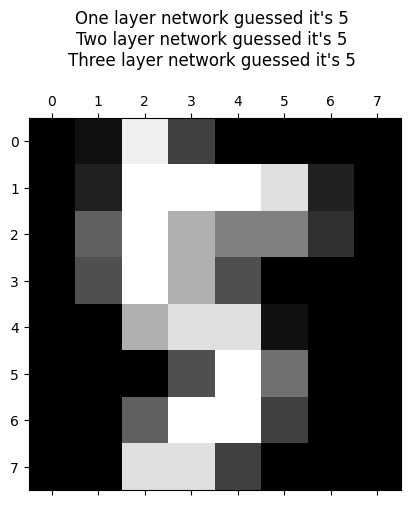

<Figure size 640x480 with 0 Axes>

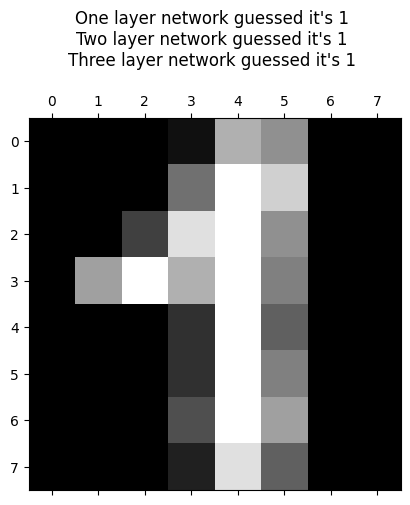

<Figure size 640x480 with 0 Axes>

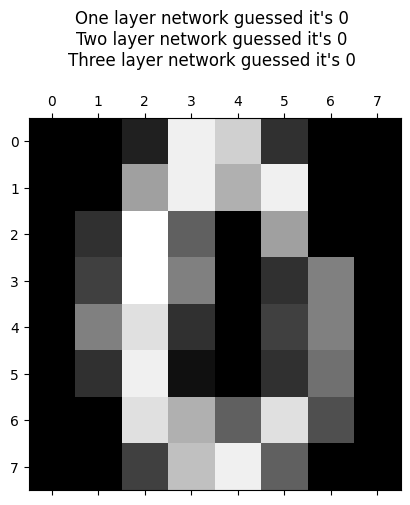

<Figure size 640x480 with 0 Axes>

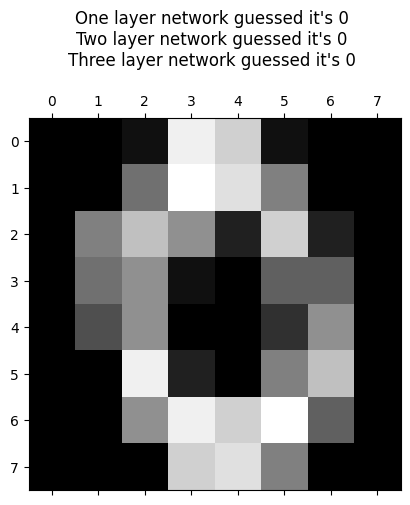

In [ ]:
digits = load_digits()

for i in range(50):
    plt.gray()
    plt.matshow(digits.images[i])
    plt.title(f"One layer network guessed it's {np.argmax(one_layer_network(digits.data[i]))} \n" +\
    f"Two layer network guessed it's {np.argmax(two_layer_network(digits.data[i]))} \n" +\
    f"Three layer network guessed it's {np.argmax(three_layer_network(digits.data[i]))} \n")
    plt.show()

In [ ]:
xor_network = create_network([(2, 2), (2, 2)], 0.05)
x_train = x_test = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
y_train = y_test = np.array([0, 1, 0, 1])
losses, accuracies = xor_network.fit(x_train, y_train, 100, x_test, y_test, 1)

Epoch 0/100, Loss: 3.8787890515671846
Epoch 1/100, Loss: 3.776198048622943
Epoch 2/100, Loss: 3.3429894434361707
Epoch 3/100, Loss: 3.1065898662553133
Epoch 4/100, Loss: 2.937306292283938
Epoch 5/100, Loss: 2.7997391025560714
Epoch 6/100, Loss: 2.6863910420471497
Epoch 7/100, Loss: 2.5933509935968075
Epoch 8/100, Loss: 2.51667935229748
Epoch 9/100, Loss: 2.452531662855962
Epoch 10/100, Loss: 2.397608922862275
Epoch 11/100, Loss: 2.3492837829783606
Epoch 12/100, Loss: 2.30552210922825
Epoch 13/100, Loss: 2.2647522600492973
Epoch 14/100, Loss: 2.225745455609209
Epoch 15/100, Loss: 2.1875197781850346
Epoch 16/100, Loss: 2.149265149184209
Epoch 17/100, Loss: 2.1102859024828415
Epoch 18/100, Loss: 2.0699596654974877
Epoch 19/100, Loss: 2.027712278021081
Epoch 20/100, Loss: 1.9830081320702364
Epoch 21/100, Loss: 1.9353543589559399
Epoch 22/100, Loss: 1.8843163283369786
Epoch 23/100, Loss: 1.8295411543411868
Epoch 24/100, Loss: 1.7707853452526918
Epoch 25/100, Loss: 1.707942454434183
Epoch 26

In [ ]:
for inputs in x_test:
    print(f"On inputs {inputs} xor network guess the result is {np.argmax(xor_network(inputs))}")

On inputs [0 0] xor network guess the result is 0
On inputs [0 1] xor network guess the result is 1
On inputs [1 1] xor network guess the result is 0
On inputs [1 0] xor network guess the result is 1


In [ ]:
xor_network = create_network([(2, 2)], 0.001)
x_train = x_test = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
y_train = y_test = np.array([0, 1, 0, 1])
losses, accuracies = xor_network.fit(x_train, y_train, 100, x_test, y_test, 1)

Epoch 0/100, Loss: 2.4873766376632163
Epoch 1/100, Loss: 2.4815111796176237
Epoch 2/100, Loss: 2.475707649825412
Epoch 3/100, Loss: 2.469966115718673
Epoch 4/100, Loss: 2.4642866232002136
Epoch 5/100, Loss: 2.4586691969975627
Epoch 6/100, Loss: 2.453113841025023
Epoch 7/100, Loss: 2.4476205387532057
Epoch 8/100, Loss: 2.4421892535855023
Epoch 9/100, Loss: 2.4368199292409733
Epoch 10/100, Loss: 2.431512490143111
Epoch 11/100, Loss: 2.4262668418139866
Epoch 12/100, Loss: 2.421082871273259
Epoch 13/100, Loss: 2.415960447441585
Epoch 14/100, Loss: 2.4108994215479265
Epoch 15/100, Loss: 2.4058996275403124
Epoch 16/100, Loss: 2.400960882499595
Epoch 17/100, Loss: 2.3960829870557654
Epoch 18/100, Loss: 2.3912657258063925
Epoch 19/100, Loss: 2.3865088677367896
Epoch 20/100, Loss: 2.3818121666414847
Epoch 21/100, Loss: 2.377175361546623
Epoch 22/100, Loss: 2.372598177132912
Epoch 23/100, Loss: 2.368080324158746
Epoch 24/100, Loss: 2.363621499883162
Epoch 25/100, Loss: 2.359221388488277
Epoch 26

In [ ]:
for inputs in x_test:
    print(f"On inputs {inputs} xor network guess the result is {np.argmax(xor_network(inputs))}")

On inputs [0 0] xor network guess the result is 0
On inputs [0 1] xor network guess the result is 0
On inputs [1 1] xor network guess the result is 1
On inputs [1 0] xor network guess the result is 1
